# Machine Learning Fundamentals - Lecture 04

This is the Jupyter notebook for Lecture 04 of the Machine Learning Fundamentals
course.

In [ ]:
# Import the required libraries using the commonly use short names (pd, sns, ...)
import numpy as np
import pandas as pd

# The Path object from pathlib allows us to easily build paths in an
# OS-independent fashion
from pathlib import Path

# This will help us cycle through the predefined color list (colormap) of a
# matplotlib plot
from itertools import cycle

# Load the required scikit-learn classes and functions
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Get the colors array from the current matplotlib colormap
# We'll cycle through these predefined colors in each plot to keep consistency
# and so that our plots don't look horrible with colors chosen by us
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Part 1: load and clean the Pokémon dataset

Here we just repeat the steps already done in the previous lectures, but in a
more succint way.

In [215]:
# Load the dataset (note the use of the Path object)
df = pd.read_csv(Path("..", "datasets", "Pokemon.csv"))

# it's not good practice to have column names with spaces and other non-standard
# characters, so Let's fix this by renaming the columns to standard names
df.rename(columns={
    "Type 1" : "Type1",
    "Type 2" : "Type2",
    "Sp. Atk" : "SpAtk",
    "Sp. Def" : "SpDef",
}, inplace=True)

# Replace missing values in the "Type2" column with the string "None"
df["Type2"] = df["Type2"].fillna("None")

# Since primary and secondary types are essentially categories (and not just
# strings / objects), we can convert these columns to the category type
df["Type1"] = df["Type1"].astype("category")
df["Type2"] = df["Type2"].astype("category")

## Part 2: Visualize the 1D regression function for predicting Total from Attack

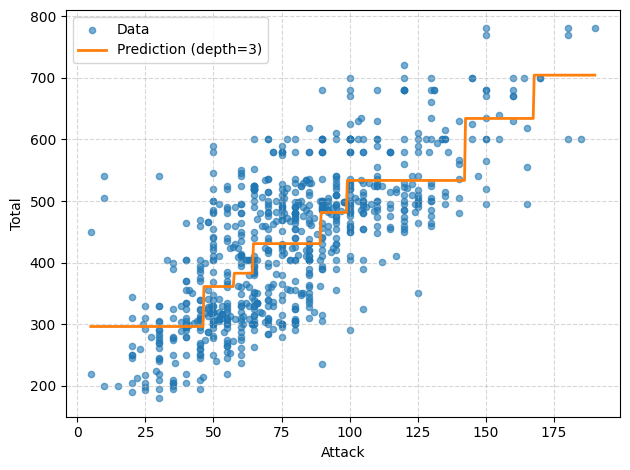

In [216]:
# 1D regression: predict Total from Attack
X = df[["Attack"]].to_numpy()
y = df["Total"].to_numpy()

# Max depth: change this to see how the regression line changes
max_depth = 3

# Fit regression tree
# - Note we're using the whole training data! Our goal here is only to plot a
# (mostly) continuous regression line so we get an intuition of how the
# decision tree regressor works
# - See part 4 below to see an actual prediction being made
tree_1d = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
tree_1d.fit(X, y)

# Create test data for plotting: we basically create a lot of points so we can
# draw a continuous line connecting them
# The reshape(-1, 1) at the end converts the vector returned by linspace into
# a [500, 1] matrix (the -1 means use the complete length of values)
X_test = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred = tree_1d.predict(X_test)

# Let's create the plot
cycler = cycle(colors) # Color cycler
fig1, ax1 = plt.subplots()
ax1.scatter(X, y, s=20, alpha=0.6, color=next(cycler), label="Data")
ax1.plot(X_test, y_pred, color=next(cycler), linewidth=2, label=f"Prediction (depth={max_depth})")
ax1.set_xlabel("Attack")
ax1.set_ylabel("Total")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)
fig1.tight_layout()

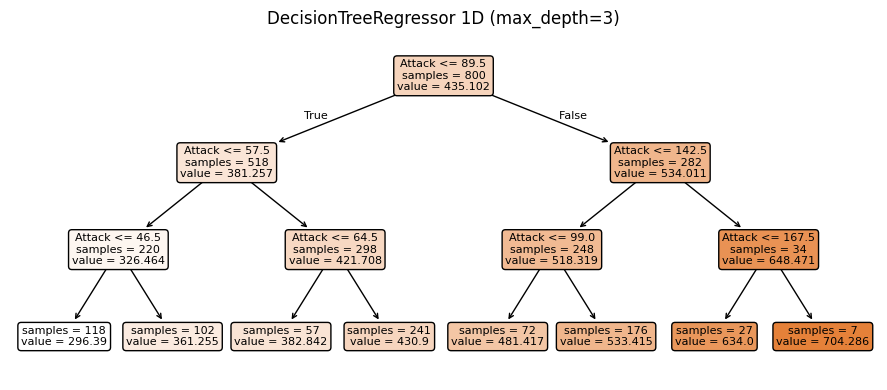

In [217]:
# Let's check out the actual regression tree created by the regressor above
fig1t, ax1t = plt.subplots(figsize=(9, 4))
plot_tree(
    tree_1d,
    feature_names=["Attack"],
    filled=True,
    rounded=True,
    impurity=False,
    proportion=False,
    fontsize=8,
    ax=ax1t
)

ax1t.set_title(f"DecisionTreeRegressor 1D (max_depth={max_depth})")
fig1t.tight_layout()

Note that the CART algorithm (employed in scikit-learn) reuses features at each
tree level, contrary to what is done by ID3.

## Part 3: Visualize the 2D regression function for predicting Total from Attack and Defense

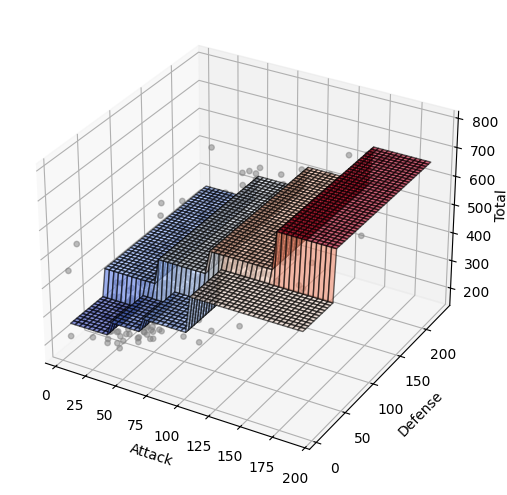

In [218]:
# 2D regression: predict Total from Attack and Defense ---
X2 = df[["Attack", "Defense"]].values
y2 = df["Total"].values

# Max depth: change this to see how the regression line changes
max_depth = 3

# Fit regression tree
# - Note we're using the whole training data! Our goal here is only to plot a
# (mostly) continuous regression planes so we get an intuition of how the
# decision tree regressor works in 2D regression
# - See part 4 below to see an actual prediction being made
tree_2d = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
tree_2d.fit(X2, y2)

# Create test data for plotting: we basically create a lot of points so we can
# draw a continuous line connecting them. Let's go step by step, as this is
# somewhat more convoluted than in the 1D case:

# Create equally spaced points for each of the 2 dimensions
# We're basing ourselves in the actual dimension of the train data (attack and defense)
x1 = np.linspace(X2[:, 0].min(), X2[:, 0].max(), 50)
x2 = np.linspace(X2[:, 1].min(), X2[:, 1].max(), 50)

# Get a tuple of coordinate matrices from coordinate vectors (basically create a
# grid of all combinations of x1 and x2 values)
xx1, xx2 = np.meshgrid(x1, x2)

# Combine xx1 and xx2: now we get a proper "X" matrix, with rows being
# observations and columns the features (50x50=2500 observations, 2 features)
X_grid = np.column_stack((xx1.ravel(), xx2.ravel()))

# Perform the prediction over all of these "training" points to get the
# regression planes
y_pred2 = tree_2d.predict(X_grid).reshape(xx1.shape)

# Let's create the plot
fig2 = plt.figure(figsize=(5, 5))
ax2 = fig2.add_subplot(111, projection="3d")

# Plot the actual data points, so we can have some insight on how the regression
# planes are predicted
ax2.scatter(X2[:, 0], X2[:, 1], y2, color="gray", s=15, alpha=0.5, label="Data")

# Plot regression "surface" (piecewise-constant planes)
ax2.plot_surface(xx1, xx2, y_pred2, cmap="coolwarm", alpha=0.6, edgecolor="k")

ax2.set_xlabel("Attack")
ax2.set_ylabel("Defense")
ax2.set_zlabel("Total", labelpad=0)

fig2.tight_layout()

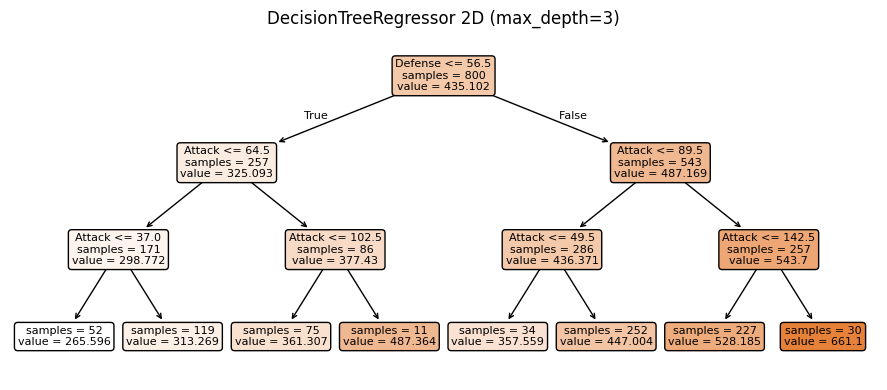

In [219]:
# Let's check out the actual regression tree created by the 2D regressor above
fig2t, ax2t = plt.subplots(figsize=(9, 4))

plot_tree(
    tree_2d,
    feature_names=["Attack", "Defense"],
    filled=True,
    rounded=True,
    impurity=False,
    proportion=False,
    fontsize=8,
    ax=ax2t
)

ax2t.set_title(f"DecisionTreeRegressor 2D (max_depth={max_depth})")
fig2t.tight_layout()

## Part 4: Compare $R^2$ for different tree depths

$R^2$, also called the _coefficient of determination_, measures how well a
regression model's predictions match the actual data. It represents the
proportion of variance in the target variable that's explained by the model.

An $R^2$ of 1 means perfect predictions, 0 means the model is no better than
predicting the mean, and negative values mean it's worse than that.

In this part we'll take a look at how $R^2$ changes for different values of
`max_depth` for the 1D regression tree case. For this purpose, we'll train two
tree models with different depths using only the training data. The test data
will be used to assess how well each tree generalizes beyond the training data.

We'll plot the regression lines anyway, which gives us an idea of how far the
test data is from those lines. The farthest the test data is from those lines,
the lowest $R^2$ will be (which means a worse prediction).

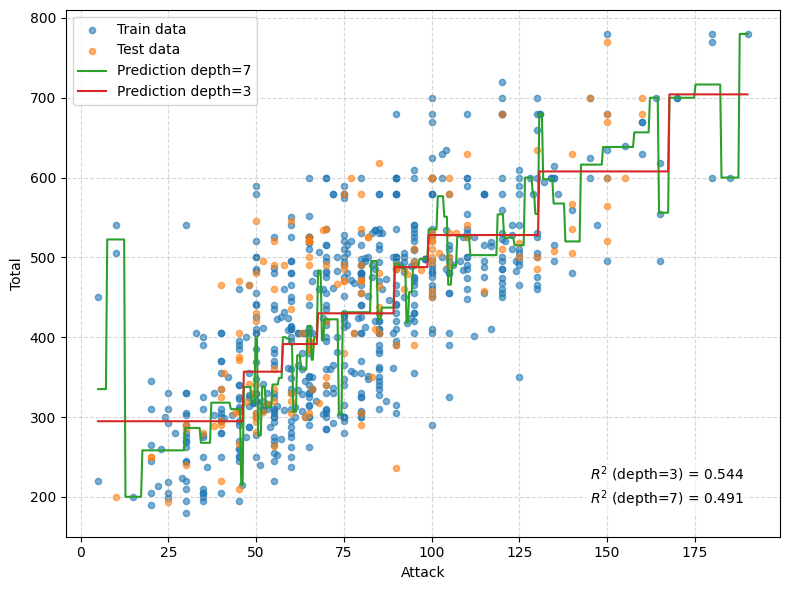

In [220]:

# 1D regression: predict Total from Attack
X = df[["Attack"]].to_numpy()
y = df["Total"].to_numpy()

# Split into training and test sets, no need for scaling in Decision Trees
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit regression tree for different max_depths
tree_1d_depth3 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_1d_depth3.fit(X_train, y_train)

tree_1d_depth7 = DecisionTreeRegressor(max_depth=7, random_state=42)
tree_1d_depth7.fit(X_train, y_train)

# Create test grid for plotting the regression lines
X_pred_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred_plot_depth3 = tree_1d_depth3.predict(X_pred_plot)
y_pred_plot_depth7 = tree_1d_depth7.predict(X_pred_plot)

# Make the actual predictions with test data for which we have the true labels
y_pred_test_depth3 = tree_1d_depth3.predict(X_test)
y_pred_test_depth7 = tree_1d_depth7.predict(X_test)

# Get the R^2 scores for each three
r2_d3 = r2_score(y_test, y_pred_test_depth3)
r2_d7 = r2_score(y_test, y_pred_test_depth7)

# Create a new color cycler
cycler = cycle(colors)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# First, plot the training data
ax.scatter(X_train, y_train, s=20, color=next(cycler), alpha=0.6, label="Train data")

# Then the test data
ax.scatter(X_test.ravel(), y_test, s=20, color=next(cycler), alpha=0.6, label="Test data")

# Now let's plot the regression lines for each tree
ax.plot(X_pred_plot, y_pred_plot_depth7, color=next(cycler), linewidth=1.5, label="Prediction depth=7")
ax.plot(X_pred_plot, y_pred_plot_depth3, color=next(cycler), linewidth=1.5, label="Prediction depth=3")

# Labels, legend, and background grid
ax.set_xlabel("Attack")
ax.set_ylabel("Total")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

# Present the R^2's directly in the figure
ax.text(
    0.95, 0.05, # (x, y) in axes fraction coordinates
    f"$R^2$ (depth=3) = {r2_d3:.3f}\n$R^2$ (depth=7) = {r2_d7:.3f}",
    transform=ax.transAxes, # interpret (x, y) as fraction of Axes
    ha="right", va="bottom", # align text to right bottom corner
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
)

fig.tight_layout()

The regression line for depth=7, in green, shows that the tree overfits the
train data, while for depth=3, the regression line just follows the general
trend, without "becoming addicted" to specific training data details.

We confirm that the tree with depth=3 generalizes better to the test data, since
it has a higher $R^2$ than the tree with depth=7.